# Images consumption and EDA

In [54]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import os

#### Mounting Google Drive to read dataset

In [55]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
full_path = '/content/drive/MyDrive/ML Project/data/icml_face_data.csv'

In [57]:
full_df = pd.read_csv(full_path)

In [58]:
full_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [59]:
full_df.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

### EDA

In [60]:
def plot_count_with_labels(data, column, title, figsize=(9, 6), fontsize=8):
    """
    Creates a countplot with count and percent labels on top of each bar.

    Args:
        data (DataFrame): The input DataFrame.
        column (str): The column name for which to create the countplot.
        title (str): The title of the plot.
        figsize (tuple): The size of the figure (width, height).
        fontsize (int): The fontsize for the count and percent labels.

    Returns:
        None
    """
    sns.set(style="darkgrid")  # Set the style of the plot
    
    # Create the countplot with adjusted figure size
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=column, data=data, order=data[column].value_counts().index)
    
    # Calculate total count
    total_count = data[column].count()
    
    # Add count and percent labels on top of the bars with adjusted fontsize
    for p in ax.patches:
        count = p.get_height()
        percent = (count / total_count) * 100
        label = f"{count} | {percent:.2f}%"
        ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                    fontsize=fontsize)
    
    # Set x-tick labels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=fontsize)
    
    # Set plot title with adjusted fontsize
    ax.set_title(title, fontsize=fontsize)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


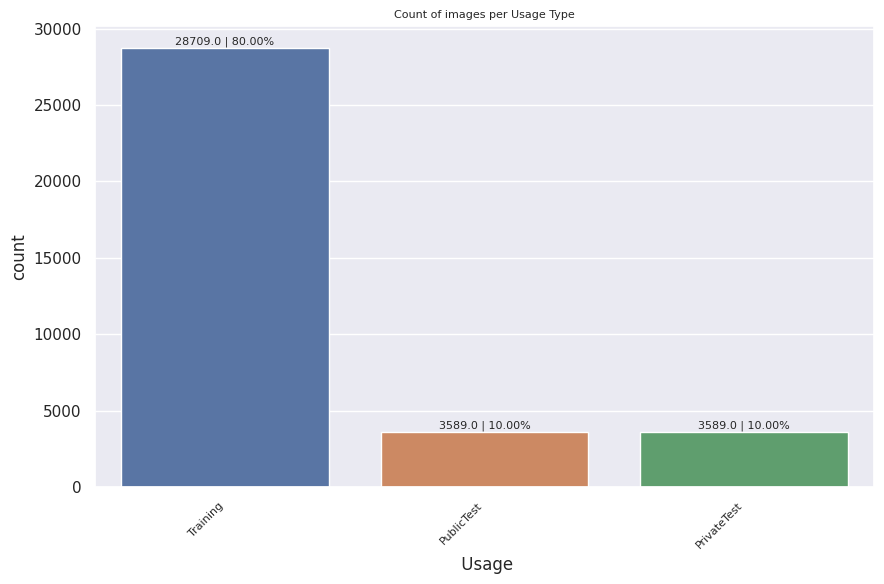

In [61]:
plot_count_with_labels(full_df, ' Usage', 'Count of images per Usage Type')

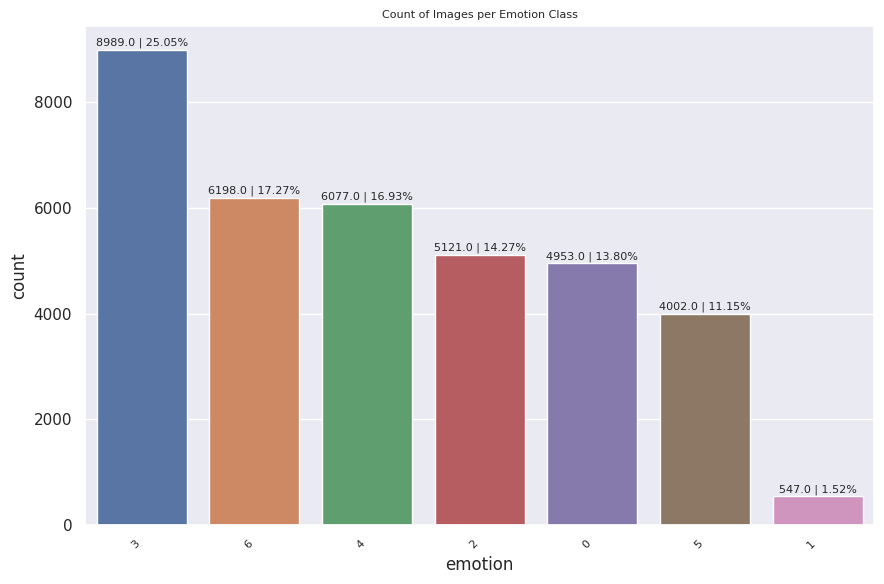

In [62]:
plot_count_with_labels(full_df, 'emotion', 'Count of Images per Emotion Class')

## Feature engineering

In [63]:
# dictionary definition of emotion mapping
emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# create the 'emotion_class' column by mapping the 'emotion' column
full_df['emotion_class'] = full_df['emotion'].map(emotion_mapping)

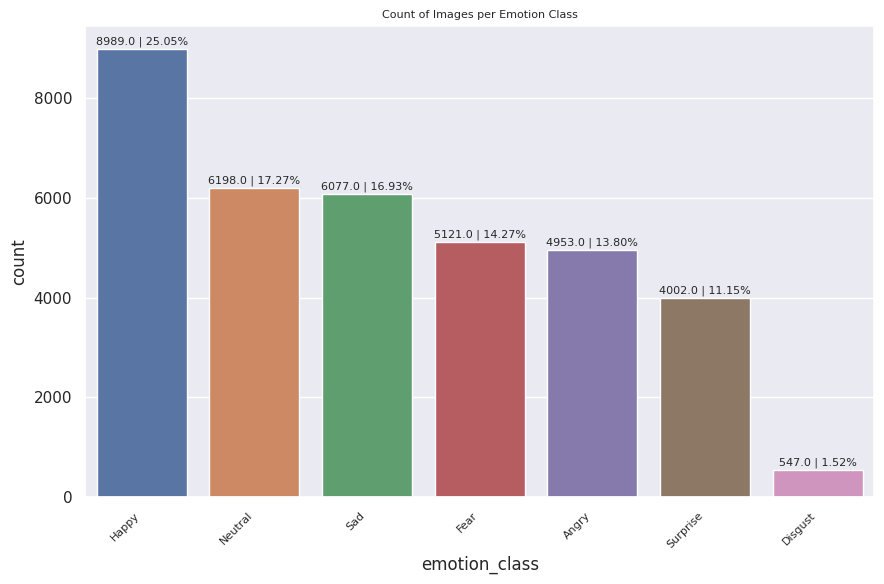

In [64]:
plot_count_with_labels(full_df, 'emotion_class', 'Count of Images per Emotion Class')

## Image data preparation

In [65]:
from tensorflow.keras.utils import to_categorical

def preprocess_data(df):
    """
    Preprocesses the input data to train a neural network model.

    Args:
        train_df (DataFrame): Training DataFrame with 'emotion' and 'pixels' columns.

    Returns:
        tuple: A tuple containing the preprocessed training images and labels.
    """
    # Preprocess the input data
    input_shape = (48, 48, 1)  # Shape of input images
    num_classes = 7  # Number of classes for classification

    # Convert pixel values to numpy array and reshape them to images
    imgs = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in df[' pixels']])
    imgs = imgs.reshape(-1, 48, 48, 1)

    # Normalize the pixel values between 0 and 1
    imgs = imgs / 255.0

    # Convert the target labels to categorical format
    lbls = to_categorical(df['emotion'], num_classes)

    return imgs, lbls

Preprocess training

In [66]:
train_imgs, train_lbls = preprocess_data(full_df[full_df[" Usage"] == "Training"])
val_imgs, val_lbls = preprocess_data(full_df[full_df[" Usage"] == "PrivateTest"])
test_imgs, test_lbls = preprocess_data(full_df[full_df[" Usage"] == "PublicTest"])

In [67]:
print(f'Shape of training data: {np.shape(train_imgs)}')
print(f'Shape of testing data: {np.shape(test_imgs)}')
print(f'Shape of validation data: {np.shape(val_imgs)}')

Shape of training data: (28709, 48, 48, 1)
Shape of testing data: (3589, 48, 48, 1)
Shape of validation data: (3589, 48, 48, 1)


## Visualizing some of the images

In [68]:
import matplotlib.pyplot as plt

def show_image(image):
    """
    Displays a single image in a Jupyter Notebook.

    Args:
        image (ndarray): NumPy array of the image to be displayed.
    """
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

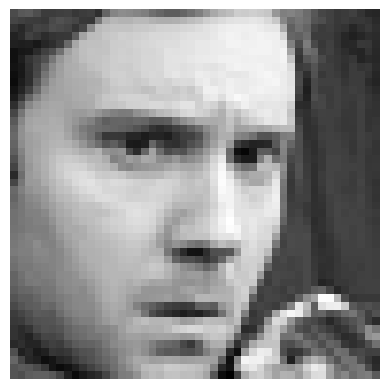

In [69]:
show_image(train_imgs[0])

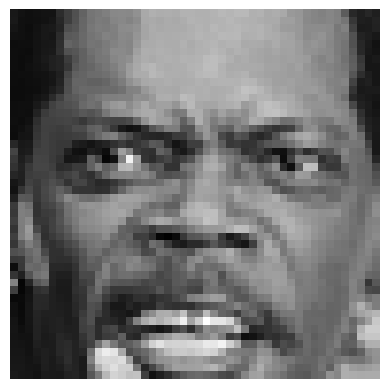

In [70]:
show_image(train_imgs[10])

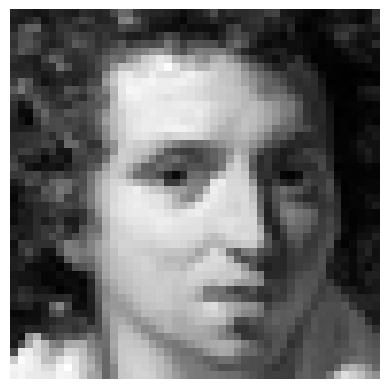

In [71]:
show_image(train_imgs[1000])

## Visualizing 2 images per emotion

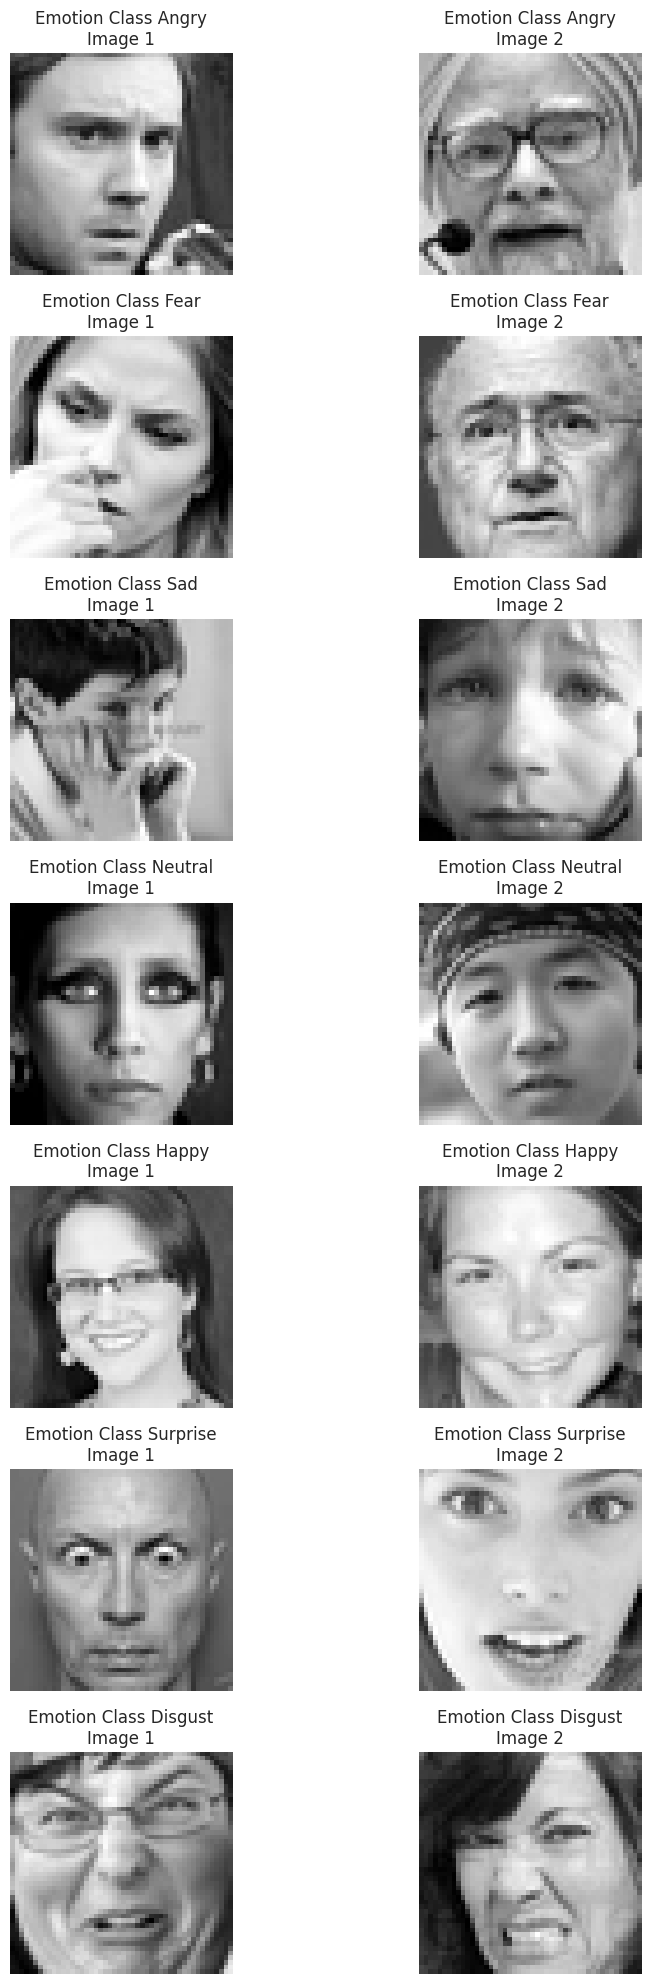

In [72]:
import matplotlib.pyplot as plt

# Define the grid size
num_classes = 7
num_images_per_class = 2
grid_size = (num_classes, num_images_per_class)

# Create a figure and axis objects
fig, axs = plt.subplots(*grid_size, figsize=(10, 20))

# Iterate over the emotion classes
for i, emotion_class in enumerate(full_df['emotion_class'].unique()):
    # Get the images for the current emotion class
    class_images = full_df[full_df['emotion_class'] == emotion_class][' pixels'].head(num_images_per_class)

    # Iterate over the images for the current emotion class
    for j, image in enumerate(class_images):
        # Convert the numeric grayscale representation to an image array
        image_array = np.array(image.split(), dtype='uint8').reshape(48, 48)

        # Plot the image in the corresponding grid cell
        axs[i, j].imshow(image_array, cmap='gray')
        axs[i, j].axis('off')

        # Add a title to the plot
        axs[i, j].set_title(f'Emotion Class {emotion_class}\nImage {j+1}')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot as an image
plt.savefig('emotion_images.png')

# Show the plot
plt.show()

## Data Augmentation
Horizontal shifting to maintain faces features and avoid mis-classification. 

In [74]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

# Define data augmentation parameters
datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1)

# Convert one-hot encoded labels back to categorical format
categorical_lbls = np.argmax(train_lbls, axis=1)

# Select 'disgust' class images
disgust_imgs = train_imgs[categorical_lbls == 1]

# Reshape the images to have 4 dimensions because ImageDataGenerator requires it
disgust_imgs = disgust_imgs.reshape((disgust_imgs.shape[0], disgust_imgs.shape[1], disgust_imgs.shape[2], 1))

# Prepare a list to store augmented images
augmented_disgust_imgs = []

# Loop over images in disgust_imgs
for img in disgust_imgs:
    img = img.reshape((1,) + img.shape)
    aug_iter = datagen.flow(img)

    # Generate 2000 // len(disgust_imgs) new images for each original image
    for i in range(2000 // len(disgust_imgs)):
        augmented_img = next(aug_iter)[0].astype(np.float32)
        augmented_disgust_imgs.append(augmented_img)

# Make sure the total number of augmented images is exactly 2000
while len(augmented_disgust_imgs) < 2000:
    augmented_disgust_imgs.append(next(datagen.flow(disgust_imgs[0].reshape((1,) + disgust_imgs[0].shape)))[0].astype(np.float32))

# Convert the list of augmented images to numpy array
augmented_disgust_imgs = np.array(augmented_disgust_imgs)

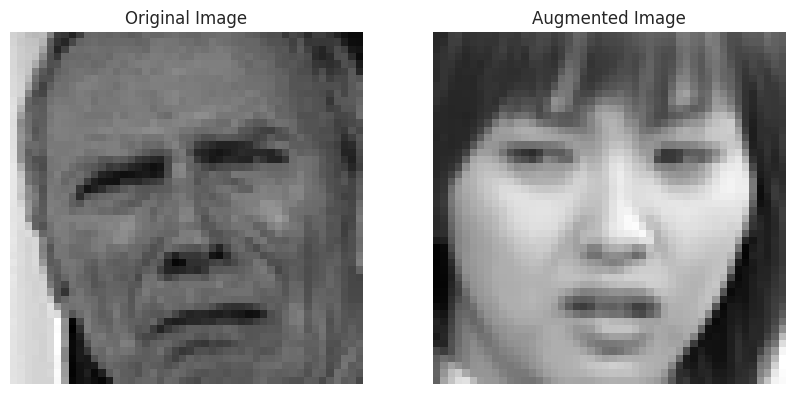

In [75]:
# Select a random image index
img_index = np.random.randint(len(disgust_imgs))

# Get the original image and its augmented version
original_img = disgust_imgs[img_index].reshape((disgust_imgs.shape[1], disgust_imgs.shape[2]))
augmented_img = augmented_disgust_imgs[img_index].reshape((disgust_imgs.shape[1], disgust_imgs.shape[2]))

# Plot original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Plot augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_img, cmap='gray')
plt.title("Augmented Image")
plt.axis('off')

# Show the plot
plt.show()

Let's add the newly generated 'Disgust' class faces to the training dataset

In [79]:
# Create labels for the augmented 'disgust' class images
augmented_disgust_labels = np.zeros((augmented_disgust_imgs.shape[0], train_lbls.shape[1]))
augmented_disgust_labels[:, 1] = 1.0

In [80]:
# Append augmented images to the original training images
train_imgs_augmented = np.concatenate((train_imgs, augmented_disgust_imgs), axis=0)

# Append labels of the augmented images to the original training labels
train_lbls_augmented = np.concatenate((train_lbls, augmented_disgust_labels), axis=0)

In [81]:
from sklearn.utils import shuffle

train_imgs_augmented, train_lbls_augmented = shuffle(train_imgs_augmented, train_lbls_augmented, random_state=42)

## Save numpy arrays

In [82]:
import numpy as np
import shutil

def save_arrays_to_drive(imgs, lbls, destination_folder, imgs_filename, lbls_filename):
    """
    Saves the imgs and lbls arrays to Google Drive.

    Args:
        imgs (ndarray): NumPy array of training images.
        lbls (ndarray): NumPy array of training labels.
        destination_folder (str): The path to the destination folder in Google Drive.
        imgs_filename (str): The filename for the train_imgs array.
        lbls_filename (str): The filename for the train_lbls array.

    Returns:
        None
    """
    # Save the imgs and lbls arrays to .npy files
    np.save(imgs_filename, imgs)
    np.save(lbls_filename, lbls)

    # Move the .npy files to the destination folder in Google Drive
    shutil.move(imgs_filename, f"{destination_folder}/{imgs_filename}")
    shutil.move(lbls_filename, f"{destination_folder}/{lbls_filename}")

In [83]:
destination_folder = "/content/drive/MyDrive/ML Project/data"
train_imgs_filename = "train_imgs.npy"
train_lbls_filename = "train_lbls.npy"
test_imgs_filename = "test_imgs.npy"
test_lbls_filename = "test_lbls.npy"
val_imgs_filename = "val_imgs.npy"
val_lbls_filename = "val_lbls.npy"

save_arrays_to_drive(train_imgs_augmented, train_lbls_augmented, destination_folder, train_imgs_filename, train_lbls_filename)
save_arrays_to_drive(test_imgs, test_lbls, destination_folder, test_imgs_filename, test_lbls_filename)
save_arrays_to_drive(val_imgs, val_lbls, destination_folder, val_imgs_filename, val_lbls_filename)